# Preparation

In [6]:
import numpy as np
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import gym
import gym_AAL

from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import RecurrentPPO

In [7]:
model_dir = "./model/best_model_1.zip"
env_id = "AAL-v0"

In [8]:
#In training, we use 8 independent environments to:
#  1)accelerate the training;  2)lower the correlation of the data
#No need to use 8 envs here
env = make_vec_env(env_id, n_envs = 1)

model = RecurrentPPO(
        "MlpLstmPolicy",
        env,
        n_steps = 128,
        learning_rate = 1e-3,
        #verbose=1,
        batch_size = 256,
        seed = 0,#1
        clip_range = 0.2,
        n_epochs = 10,
        max_grad_norm = 1,
        gamma = 0.95,
        gae_lambda = 0.95,
       # tensorboard_log= log_dir,
        policy_kwargs=dict(
            activation_fn = nn.ReLU,
            net_arch=[1, dict(pi=[1], vf=[1])],
            lstm_hidden_size=64,
            ortho_init=False,
            enable_critic_lstm=False,
            #n_lstm_layers = 2,
            #shared_lstm = True,
        ),
    )
model = RecurrentPPO.load(model_dir)

# Start the simulation

In [9]:
obs = env.reset()
lstm_states = None
episode_starts = None
num_steps_sim = 100
r = []
v1 = []
v2 = []
v3 = []
v4 = []
ca = []
total_r = 0
ca.append(obs[0][0])
v1.append(obs[0][1])
v2.append(obs[0][2])
v3.append(obs[0][3])
v4.append(obs[0][4])
r.append(0)

for i in range(num_steps_sim):
    action, lstm_states = model.predict(obs, state = lstm_states, episode_start= episode_starts, deterministic= True)
    obs, reward, done, info = env.step(action)
    episode_starts = done
    ca.append(obs[0][0])
    v1.append(obs[0][1])
    v2.append(obs[0][2])
    v3.append(obs[0][3])
    v4.append(obs[0][4])
    r.append(reward[0])
    total_r += reward[0]

    '''
        The argument 'info', which is a part of the output of step(), has two extra fields if 'is_success'=True
        They are:'episode' and 'terminal_observation'
        Example:
        'episode': {'r': 510.0, 'l': 12, 't': 6.250726},
        'terminal_observation': array([ 1.642e-04,  4.227e+00,  1.432e+00, -4.375e+00,  1.479e+00], dtype=float16)
        When 'is_success'=True, the reset() is called at once, hence the 'obs' argument returned by step() is reset (not the desired one)
        More： see venv/Lib/site-packages/stable_baselines3/common/vec_env/dummy_vec_env.py step_wait() and venv/Lib/site-packages/stable_baselines3/common/vec_env/vec_monitor.py step_wait()
    '''
    if info[0]['is_success'] == True:
        ca[-2]=info[0]['terminal_observation'][0]
        v1[-2]=info[0]['terminal_observation'][1]
        v2[-2]=info[0]['terminal_observation'][2]
        v3[-2]=info[0]['terminal_observation'][3]
        v4[-2]=info[0]['terminal_observation'][4]
        print(f'Goal reached at step {i}')
        print(f'Remaining chromatic aberration: {ca[-2]} Dpt')
        print(ca[:-1])
        s = i
        break

print(f'Total Reward: {total_r}')

Goal reached at step 11
Remaining chromatic aberration: 0.00016415119171142578 Dpt
[0.071, 0.07294, 0.072, 0.0689, 0.0638, 0.057, 0.04916, 0.04092, 0.03275, 0.02478, 0.01688, 0.0001642]
Total Reward: 510.0


# Plot the simulation result

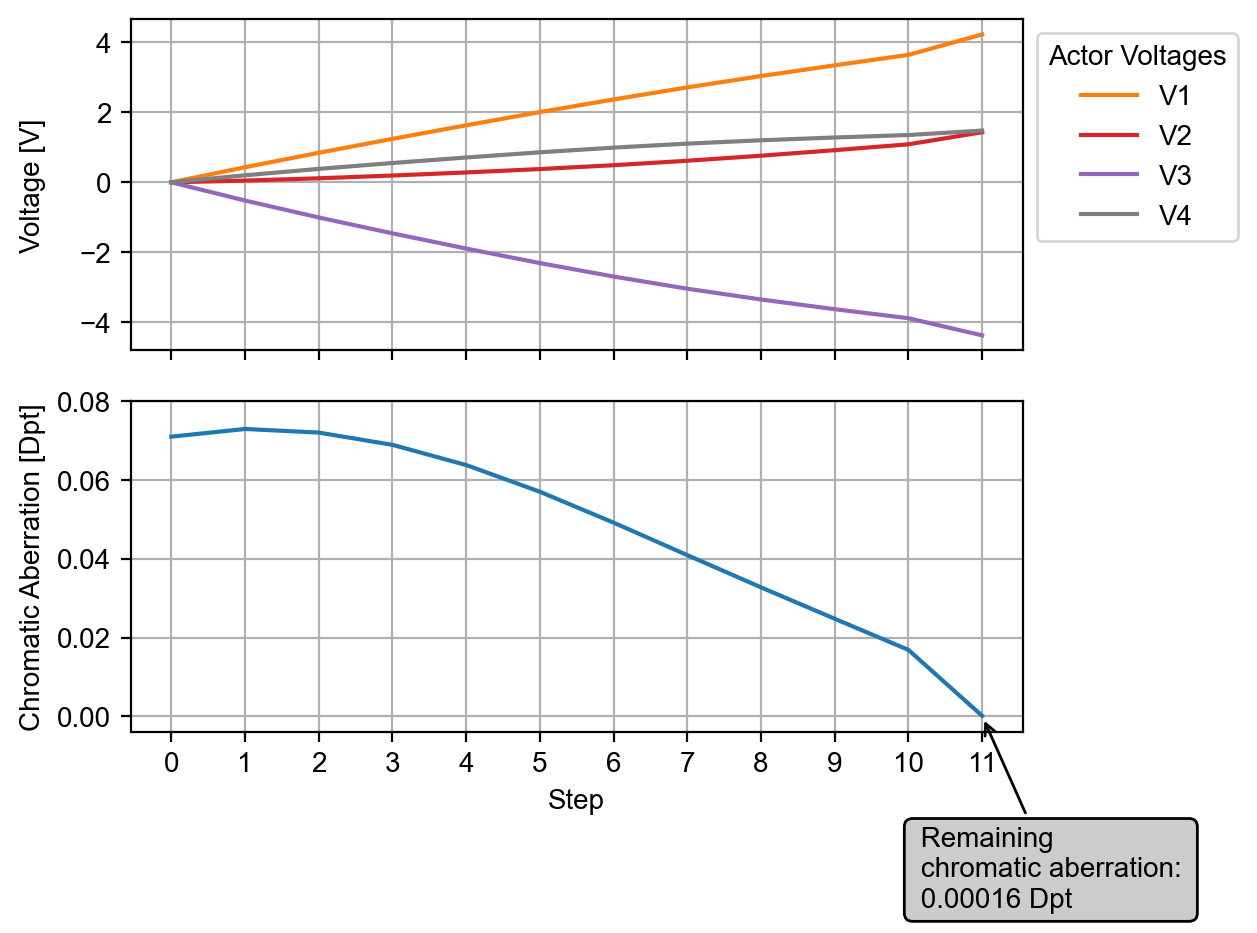

In [10]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(2,1, sharex= True)
#fig.suptitle('Simulation results of trained PPO-agent')
#x = np.arange(s)
x = np.arange(s+1)

ax[0].set_ylabel('Voltage [V]')
ax[0].plot(x, v1[:-1], label='V1', color = 'tab:orange')
ax[0].plot(x, v2[:-1], label='V2', color = 'tab:red')
ax[0].plot(x, v3[:-1], label='V3', color = 'tab:purple')
ax[0].plot(x, v4[:-1], label='V4', color = 'tab:gray')
ax[0].grid(True)
ax[0].legend(loc = 'upper left', bbox_to_anchor = (1,1), title ='Actor Voltages')

ax[1].set_ylabel('Chromatic Aberration [Dpt]')
ax[1].tick_params(axis='y')
ax[1].plot(x, ca[:-1], color = 'tab:blue')
ax[1].grid(True)
ax[1].set_xlabel('Step')
if ca[0] < 0:
    l = np.min(ca)-0.1
else:
    l = np.max(ca)+0.1
#ax[1].set_ylim((-abs(l), abs(l)))
ax[1].set_ylim(-0.004, 0.08)

#x_major_locator=plt.MultipleLocator(1)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))

label = " Remaining \n chromatic aberration: \n {:.5f} Dpt".format(ca[-2])
ax[1].annotate(label,
    #xy=(s-1, ca[-2]), xycoords = 'data',
    xy=(s, ca[-2]), xycoords = 'data',
    xytext=(-25,-40), textcoords='offset points',
    bbox=dict(boxstyle="round", fc="0.8"),
    arrowprops=dict(arrowstyle='->'),
    horizontalalignment='left',
    verticalalignment = 'top')

fig.tight_layout()
fig.align_ylabels()
fig.savefig('sim_result.svg', dpi=300, bbox_inches ='tight', transparent = True)